In [ ]:
!pip install pandas matplotlib wandb numpy

In [2]:
save_plots_dir = # add path here
wandb_user = # add wandb user here


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import wandb
import pandas as pd

def wandb_viz_loss_with_std(exp_data,y_lim=None, figsize=(10, 6), make_legend=None, legend_font=14, starting_color=0, starting_style=0, color_by_loss_type = False, style_by_loss_type=True, plot_name=None, plot_std=True, loss_types=None, save_dir=None, exclude=None, wandb_user=wandb_user, 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None, title=None, x_label=True, y_label=True):
    """
    exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...] containing labels and their experiment IDs
    """
    wandb.login()
    fig, ax1 = plt.subplots(figsize=figsize, dpi=300)
    ax2 = None
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    styles = ['-', '--', ':', '-.', '-', '--', ':', '-.']
    alphas = [1.0, 1.0]
    
    api = wandb.Api(timeout=29)
    all_losses = set()
    
    # Collect all loss types
    for _, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        for exp_n in exp_ids:
            run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
            if losses is None:
                all_losses.update([k for k in run.history().keys() if 'MSE' in k])
    
    losses = sorted(list(all_losses)) if losses is None else losses
    
    # Plot experiments
    for idx, (label, exp_ids) in enumerate(exp_data):
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids

        if not color_by_loss_type:
            base_color = colors[idx+starting_color]

        if not style_by_loss_type:
            style = styles[idx+starting_style]
        
        for idx, loss in enumerate(loss_types.keys()):
            if exclude is not None and any(loss in ex for ex in exclude):
                continue

            if color_by_loss_type:
                base_color = colors[idx+starting_color]

            if style_by_loss_type:
                style = styles[idx+starting_style]
                
            # style = styles[1] if 'val' in loss else styles[0]
            alpha = alphas[1] if 'val' in loss else alphas[0]
            
            # Collect data from all experiments
            all_data = []
            max_epoch = 0
            for exp_n in exp_ids:
                run = api.run(f"{wandb_user}/{wandb_project}/{exp_n}")
                metrics = run.history()
                iteration = metrics['epoch']
                loss_data = metrics[loss]
                valid_data = [(i, l) for i, l in zip(iteration, loss_data) if not pd.isna(l)]
                if valid_data:
                    x, y = zip(*valid_data)
                    all_data.append((x, y))
                    max_epoch = max(max_epoch, max(x))
            
            if not all_data:
                continue
            
            # If only one experiment, plot normally
            if len(exp_ids) == 1:
                x, y = all_data[0]
                ax = ax2 if vars and loss in vars else ax1
                if ax2 is None and vars and loss in vars:
                    ax2 = ax1.twinx()
                    ax2.set_ylabel("Secondary Loss Metric", fontsize=20)
                if y_lim is not None:
                    ax.set_ylim(y_lim[0], y_lim[1])
                ax.plot(x, y, label=f"{label} - {loss_types[loss] if loss_types else loss}", 
                        linestyle=style, color=base_color, alpha=alpha, linewidth=2)
            
            # For multiple experiments, calculate mean and std
            else:
                # Interpolate to common x-axis
                common_x = np.linspace(0, max_epoch, 1000)
                interpolated_y = []
                
                for x, y in all_data:
                    interpolated_y.append(np.interp(common_x, x, y))
                
                mean_y = np.mean(interpolated_y, axis=0)
                std_y = np.std(interpolated_y, axis=0)
                
                ax = ax2 if vars and loss in vars else ax1
                if y_lim is not None:
                    ax.set_ylim(y_lim[0], y_lim[1])
                if ax2 is None and vars and loss in vars:
                    ax2 = ax1.twinx()
                    ax2.set_ylabel("Secondary Loss Metric", fontsize=20)
                    if y_lim is not None:
                        ax2.set_ylim(y_lim[0], y_lim[1])

                if len(exp_data)>1:
                    prefix = f'{label} - '
                else:
                    prefix = ''
                
                ax.plot(common_x, mean_y, label=f"{prefix}{loss_types[loss] if loss_types else loss}", 
                        linestyle=style, color=base_color, alpha=alpha, linewidth=2)
                if plot_std:
                    ax.fill_between(common_x, mean_y-std_y, mean_y+std_y, color=base_color, alpha=0.2)
    
    # Rest of the styling remains the same as in original function
    if x_label:
        ax1.set_xlabel("Epoch", fontsize=20)
    if y_label:
        ax1.set_ylabel("Loss (log)", fontsize=20)
    if title:
        ax1.set_title(title, fontsize=20, pad=20)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_yscale('log')
    ax1.tick_params(axis='both', labelsize=20)
    if ax2:
        ax2.tick_params(axis='both', labelsize=20)
    
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    
    if make_legend:
        if ax2:
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            legend = ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=legend_font,
                                loc='upper right', bbox_to_anchor=(0.98, 0.98),
                                facecolor='white', edgecolor='black', framealpha=1.0)
        else:
            legend = ax1.legend(fontsize=legend_font, loc='upper right', bbox_to_anchor=(0.98, 0.98),
                                facecolor='white', edgecolor='black', framealpha=1.0)
        
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_alpha(1.0)
        #plt.tight_layout()
        
    std = 'with_std' if plot_std else 'without_std'

    if plot_name is None:
        plot_name = exp_data[0][0]

    if save_dir:
        plt.savefig(f"{save_dir}/loss_curves_{std}_{plot_name}.png", dpi=300, bbox_inches="tight")
    else:
        plt.show()
    
    plt.close()

In [4]:
def wandb_final_loss_with_std(exp_data, train_loss=None, val_loss=None, test_loss=None, loss_types=None, save_dir=None, exclude=None, wandb_user=wandb_user, 
                            wandb_project='structure-preserving-operator-learning', losses=None, vars=None):
    """
    Prints a table of averaged final losses and their standard deviations for each loss type.
    
    Args:
        exp_data: list of tuples [(label, [exp_id1, exp_id2, ...]), ...]
        loss_types: dict mapping loss variable names (in wandb) to display names
    """
    wandb.login()
    api = wandb.Api(timeout=29)

    if loss_types is None:
        raise ValueError("loss_types must be provided and map wandb variable names to display labels.")

    table_rows = []

    for label, exp_ids in exp_data:
        exp_ids = [exp_ids] if isinstance(exp_ids, str) else exp_ids
        row = {'Label': label}

        # Find and record the best validation loss if specified
        if val_loss:
            best_epochs = []
            for exp_id in exp_ids:
                try:
                    run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                    history = run.history(keys=[val_loss, train_loss] if train_loss else [val_loss])
                    val_values = history[val_loss].dropna().values
                    if len(val_values) > 0:
                        best_epoch = val_values.argmin()
                    
                    if train_loss:
                        train_values = history[train_loss].dropna().values
                        if len(train_values) > best_epoch:
                            train_at_best = train_values[best_epoch]
                    best_epochs.append(train_at_best)
                    
                except Exception as e:
                    print(f"Skipping run {exp_id} for validation loss due to error: {e}")
                    
        for loss_var, display_name in loss_types.items():
            final_losses = []
            
            for exp_id in exp_ids:
                try:
                    run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                    history = run.history(keys=[loss_var])
                    values = history[loss_var].dropna().values
                    if len(values) > 0:
                        final_losses.append(values[-1])
                except Exception as e:
                    print(f"Skipping run {exp_id} due to error: {e}")
            


            if final_losses:
                mean_loss = np.mean(final_losses)
                std_loss = np.std(final_losses)
                row[f"{display_name}"] = f"{mean_loss:.6f} ± {std_loss:.6f}"
            else:
                row[f"{display_name}"] = "N/A"

            if final_losses and val_loss and test_loss:
                if loss_var == test_loss:
                    gen_error = np.abs(final_losses - train_at_best)
                    mean_loss = np.mean(gen_error)
                    std_loss = np.std(gen_error)
                    row[f"{display_name}-gen_error"] = f"{mean_loss:.6f} ± {std_loss:.6f}"
                
            if loss_var == val_loss:
                rel_train_val_diffs = []
                for exp_id in exp_ids:
                    try:
                        run = api.run(f"{wandb_user}/{wandb_project}/{exp_id}")
                        history = run.history(keys=[train_loss, val_loss])
                        train_values = history[train_loss].dropna().values
                        val_values = history[val_loss].dropna().values
                        min_len = min(len(train_values), len(val_values))
                        if min_len > 0:
                            rel_diff = np.mean(np.abs(val_values[:min_len] - train_values[:min_len])/train_values[:min_len])
                            rel_train_val_diffs.append(rel_diff)
                    except Exception as e:
                        print(f"Skipping run {exp_id} for train-val difference due to error: {e}")

                if rel_train_val_diffs:
                    mean_diff = np.mean(rel_train_val_diffs)
                    std_diff = np.std(rel_train_val_diffs)
                    row["train-val difference"] = f"{mean_diff:.6f} ± {std_diff:.6f}"
                else:
                    row["train-val difference"] = "N/A"
        table_rows.append(row)

    df = pd.DataFrame(table_rows)
    print(df.to_string(index=False))
    
    if save_dir:
        df.to_csv(f"{save_dir}/final_loss_summary_{exp_data[0][0]}.csv", index=False)

In [5]:
def visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_dir, legend_font=14, y_lim=None, make_legend=True, title=False, x_label=True, y_label=True):
    # List to store DataFrames
    dfs = []
    
    # Read all CSV files for the given parameters
    for exp_num in experiment_numbers:
        data_dir = f'/Users/XXXX/oxford_code/structure_preserving_operator_learning/methods/deeponet/experiments/{experiment_name}/exp_n_{exp_num}/plots'
        csv_path = f'{data_dir}/data_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_val.csv'
        
        try:
            df = pd.read_csv(csv_path)
            dfs.append(df)
        except FileNotFoundError:
            print(f"Warning: File {csv_path} not found")
    
    if not dfs:
        print("No data files found")
        return
        
    # Calculate mean and std for each column
    combined_df = pd.concat(dfs)
    mean_df = combined_df.groupby('time').mean()
    std_df = combined_df.groupby('time').std()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1, 1])
    
    colors = plt.cm.tab10(np.linspace(0, 1, 4))
    
    # Plot position/velocity data in first subplot
    ax1.plot(mean_df.index, mean_df['true_position'], '--', color=colors[0], label='true position')
    ax1.plot(mean_df.index, mean_df['predicted_position'], '-', color=colors[0], label='predicted position')
    ax1.fill_between(mean_df.index, 
                     mean_df['predicted_position'] - std_df['predicted_position'],
                     mean_df['predicted_position'] + std_df['predicted_position'],
                     color=colors[0], alpha=0.2)
    
    if 'true_velocity' in mean_df.columns:
        ax1.plot(mean_df.index, mean_df['true_velocity'], '--', color=colors[1], label='true velocity')
        ax1.plot(mean_df.index, mean_df['predicted_velocity'], '-', color=colors[1], label='predicted velocity')
        ax1.fill_between(mean_df.index,
                        mean_df['predicted_velocity'] - std_df['predicted_velocity'],
                        mean_df['predicted_velocity'] + std_df['predicted_velocity'],
                        color=colors[1], alpha=0.2)
    
    # Plot energy data in second subplot
    ax2.plot(mean_df.index, mean_df['true_energy'], '-', color=colors[2], label='true energy')
    ax2.plot(mean_df.index, mean_df['gradient_predicted_energy'], '-.', color=colors[3], label='implicit energy')
    ax2.fill_between(mean_df.index,
                     mean_df['gradient_predicted_energy'] - std_df['gradient_predicted_energy'],
                     mean_df['gradient_predicted_energy'] + std_df['gradient_predicted_energy'],
                     color=colors[3], alpha=0.2)
    
    if 'velocity_predicted_energy' in mean_df.columns:
        ax2.plot(mean_df.index, mean_df['velocity_predicted_energy'], '--', color=colors[2], label='learned energy')
        ax2.fill_between(mean_df.index,
                        mean_df['velocity_predicted_energy'] - std_df['velocity_predicted_energy'],
                        mean_df['velocity_predicted_energy'] + std_df['velocity_predicted_energy'],
                        color=colors[2], alpha=0.2)
    
    if y_lim is not None:
        ax2.set_ylim(y_lim[0], y_lim[1])
    ax1.tick_params(axis='both', labelsize=16)
    ax2.tick_params(axis='both', labelsize=16)

    # Set labels and titles
    if y_label:
        ax1.set_ylabel('Position / Velocity', fontsize=22)
    if title:
        ax1.set_title(title, fontsize=22)
    ax1.grid(True)
    if make_legend:
        ax1.legend(fontsize=legend_font, loc='lower right')
    if x_label:
        ax2.set_xlabel('Time', fontsize=22)
    if y_label:
        ax2.set_ylabel('Energy', fontsize=22)
    ax2.grid(True)
    if make_legend:
        ax2.legend(fontsize=legend_font, loc='lower right')
    
    # plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'{save_dir}/averaged_predictions_with_energy_q0={q0:.2f}_p0={p0:.2f}_omega={omega:.2f}_{experiment_label}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [6]:

vanilla = ['20250418-104243','20250418-104903','20250418-105500','20250418-110052','20250418-110707']
qr = ['20250418-111322','20250418-112756','20250418-114422','20250418-115746','20250418-121558']
normal = ['20250418-132833','20250418-134318','20250418-135356','20250418-140336','20250418-141424']
implicit = ['20250418-151029','20250418-152526','20250418-154008','20250418-155311','20250418-160620']


# vanilla = ["20250417-232810","20250417-233350","20250417-233912","20250417-234527","20250417-235130"]
# qr = ["20250417-235724", "20250418-002245", "20250418-003715", "20250418-005151", "20250418-010638"]
# normal = ["20250418-012037","20250418-013146","20250418-014214","20250418-015238","20250418-020356"]
# implicit = ["20250418-021433","20250418-022821","20250418-024205","20250418-025549","20250418-030932"]



# vanilla =["20250416-234824", "20250417-000822",	"20250417-001352",	"20250417-001916",	"20250417-002439"]
# qr = ["20250417-003016",	"20250417-004209",	"20250417-005335",	"20250417-010509",	"20250417-011628"]
# normal = ["20250417-092318",	"20250417-093241",	"20250417-095220","20250417-095220",  "20250417-100212"]
# implicit = ["20250417-012917",	"20250417-014052",	"20250417-015227",	"20250417-020402",	"20250417-021535"]

**Vanilla Plots**

In [ ]:
exp_data = [('Vanilla DeepONet',vanilla)]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, title='Vanilla DeepONet', color_by_loss_type=True, exclude=None, loss_types=loss_types, save_dir=save_plots_dir, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, title='Vanilla DeepONet', color_by_loss_type=True, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_plots_dir, make_legend=False, x_label=False)

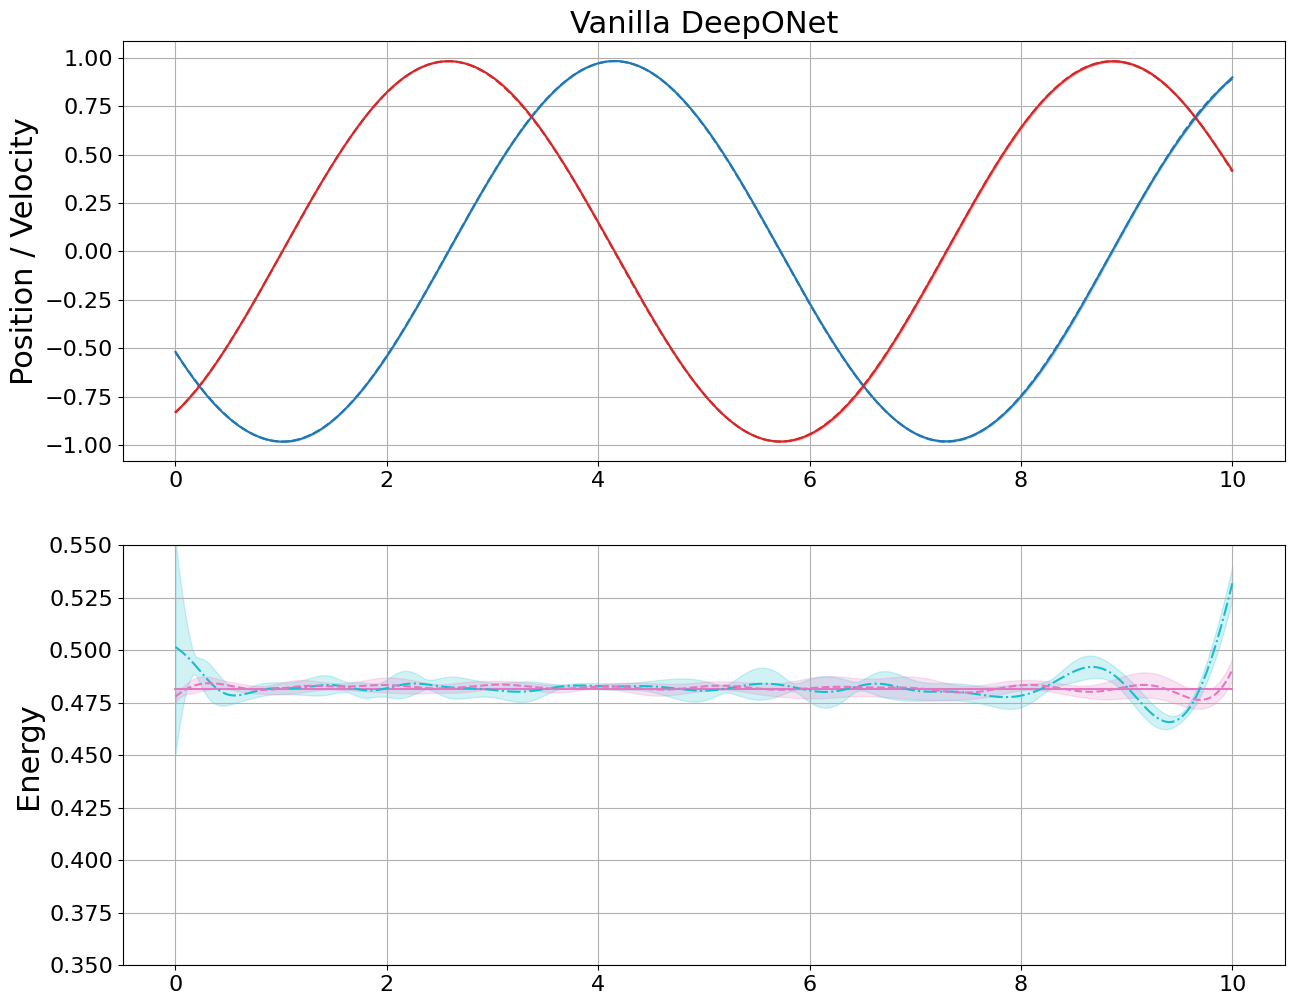

In [8]:
experiment_name = 'harmonic_osc_1_1'


experiment_label = 'Vanilla DeepONet'
experiment_numbers = vanilla

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir, title=experiment_label, y_lim=[0.35,0.55], legend_font=20, make_legend=False, x_label=False)



In [9]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, train_loss='mse_loss_train', val_loss='mse_loss_val', test_loss='mse_loss_test', loss_types=loss_types, save_dir=save_plots_dir)

           Label        training MSE      validation MSE train-val difference implicit energy MSE  learned energy MSE            test MSE  test MSE-gen_error implicit energy MSE test learned energy MSE test
Vanilla DeepONet 0.001156 ± 0.001136 0.001238 ± 0.001157  0.187076 ± 0.063447 4.672674 ± 0.009081 4.656527 ± 0.009310 0.001154 ± 0.001121 0.000955 ± 0.001121      4.551575 ± 0.006927     4.546189 ± 0.008100


**QR plots**

In [10]:
exp_data = [('QR DeepONet',qr)]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], title='QR DeepONet', color_by_loss_type=True, exclude=None, loss_types=loss_types, save_dir=save_plots_dir,y_label = False, make_legend=False, x_label=False)
wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], title='QR DeepONet', color_by_loss_type=True, plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_plots_dir,y_label = False, make_legend=False, x_label=False)

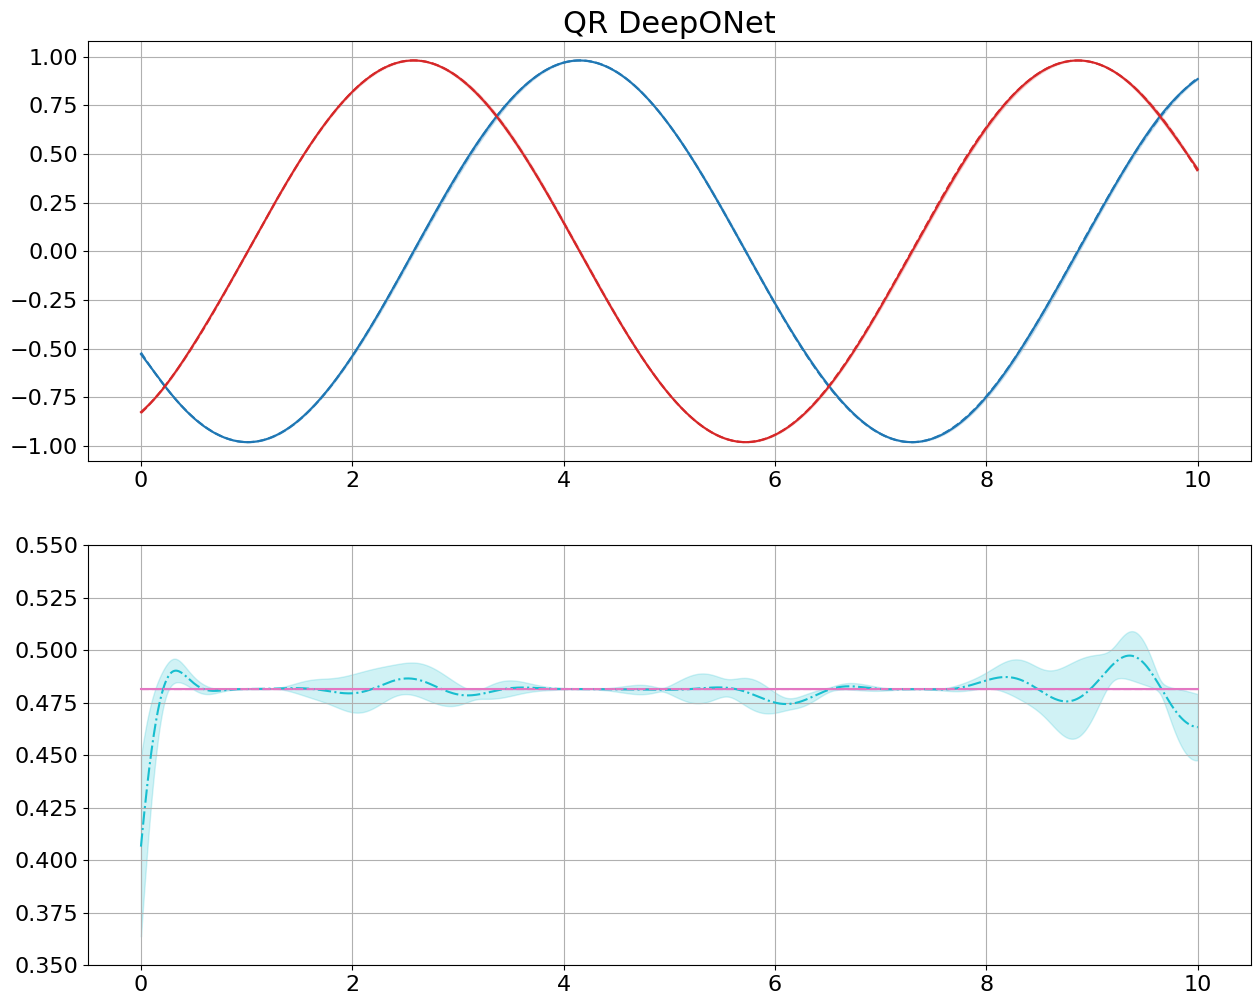

In [11]:
experiment_name = 'harmonic_osc_1_2'


experiment_label = 'QR DeepONet'
experiment_numbers = qr

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir, title=experiment_label, y_lim=[0.35,0.55], y_label=False, legend_font=20, make_legend=False, x_label=False)



In [12]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, train_loss='mse_loss_train', val_loss='mse_loss_val', test_loss='mse_loss_test', loss_types=loss_types, save_dir=save_plots_dir)

      Label        training MSE      validation MSE train-val difference implicit energy MSE  learned energy MSE            test MSE  test MSE-gen_error implicit energy MSE test learned energy MSE test
QR DeepONet 0.001408 ± 0.001194 0.001489 ± 0.001168  0.049203 ± 0.019513 8.952881 ± 0.038197 0.000000 ± 0.000000 0.001387 ± 0.001147 0.001325 ± 0.001147      8.328107 ± 0.018191     0.000000 ± 0.000000


**normalized plots**


In [13]:
exp_data = [('Normalized DeepONet',normal)]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, title='Normalized DeepONet',color_by_loss_type=True, exclude=None, loss_types=loss_types, save_dir=save_plots_dir, make_legend=True)
wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, plot_std=False, title='Normalized DeepONet',color_by_loss_type=True, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)

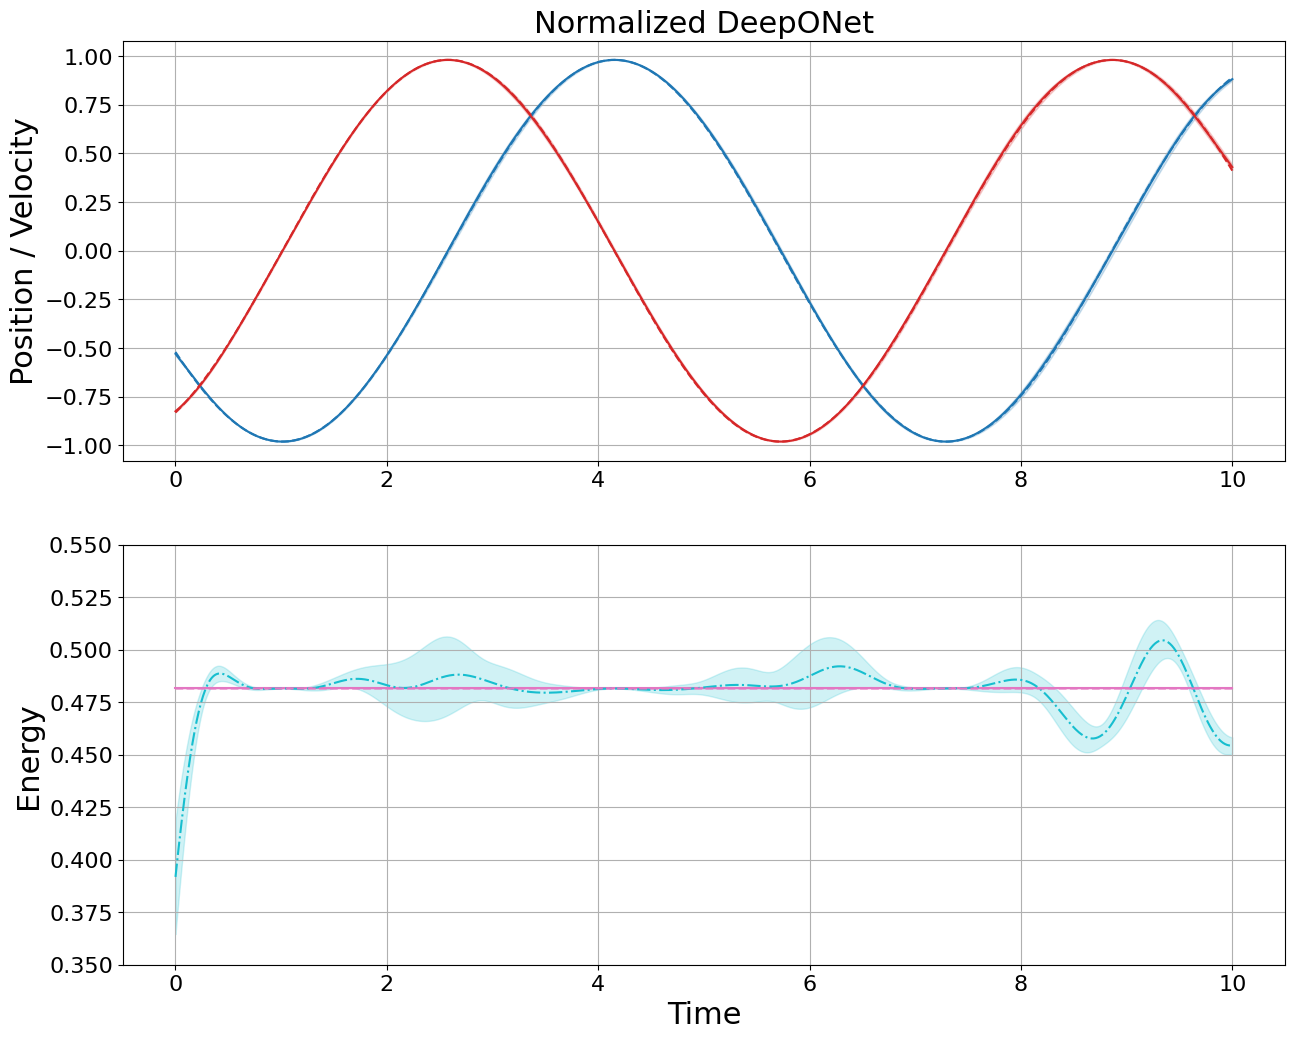

In [14]:
experiment_name = 'harmonic_osc_1_3'

experiment_label = 'Normalized DeepONet'
experiment_numbers = normal

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir, title=experiment_label, y_lim=[0.35,0.55], legend_font=20, make_legend=False)



In [15]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, train_loss='mse_loss_train', val_loss='mse_loss_val', test_loss='mse_loss_test', loss_types=loss_types, save_dir=save_plots_dir)

              Label        training MSE      validation MSE train-val difference implicit energy MSE  learned energy MSE            test MSE  test MSE-gen_error implicit energy MSE test learned energy MSE test
Normalized DeepONet 0.003414 ± 0.002549 0.003559 ± 0.002786  0.041035 ± 0.010198 0.027234 ± 0.009704 0.000000 ± 0.000000 0.003231 ± 0.002401 0.002753 ± 0.002382      0.032886 ± 0.011701     0.000000 ± 0.000000


**implicit normalized plots**

In [16]:
exp_data = [('Implicitly Normalized DeepONet',implicit)]
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE'}

wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, exclude=None, color_by_loss_type=True,loss_types=loss_types, save_dir=save_plots_dir, title='Implicitly Normalized DeepONet', y_label = False, make_legend=True)
wandb_viz_loss_with_std(exp_data, y_lim=[10**(-3.75), 10**(1.5)], legend_font=16, plot_std=False, color_by_loss_type=True,exclude=None, loss_types=loss_types, save_dir=save_plots_dir, title='Implicitly Normalized DeepONet', y_label = False, make_legend=True)

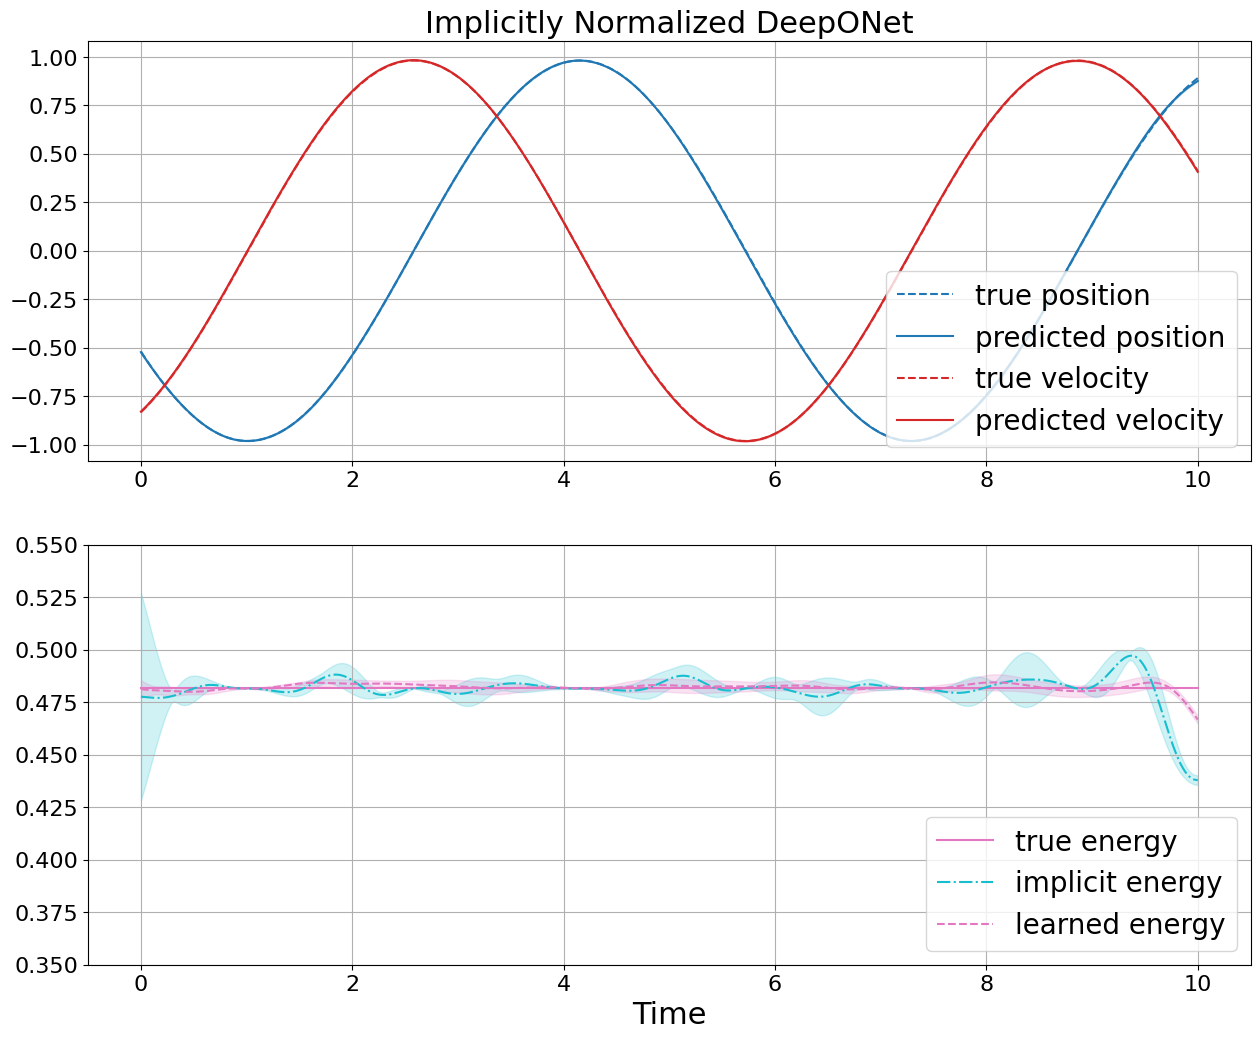

In [17]:
experiment_name = 'harmonic_osc_1_4'

experiment_label = 'Implicitly Normalized DeepONet'
experiment_numbers = implicit

q0=-.52
p0=-0.83
omega=1.0
visualize_averaged_example_with_energy(experiment_label, experiment_name, experiment_numbers, q0, p0, omega, save_plots_dir, title=experiment_label, y_label=False, y_lim=[0.35,0.55], legend_font=20, make_legend=True)


In [18]:
loss_types = {'mse_loss_train': 'training MSE', 'mse_loss_val': 'validation MSE', 'current_energy_loss_val':'implicit energy MSE', 'learned_energy_loss_val':'learned energy MSE', 'mse_loss_test':'test MSE',  'current_energy_loss_test':'implicit energy MSE test', 'learned_energy_loss_test':'learned energy MSE test'}

wandb_final_loss_with_std(exp_data, exclude=None, train_loss='mse_loss_train', val_loss='mse_loss_val', test_loss='mse_loss_test', loss_types=loss_types, save_dir=save_plots_dir)

                         Label        training MSE      validation MSE train-val difference implicit energy MSE  learned energy MSE            test MSE  test MSE-gen_error implicit energy MSE test learned energy MSE test
Implicitly Normalized DeepONet 0.000361 ± 0.000190 0.000448 ± 0.000212  0.213135 ± 0.010909 0.008308 ± 0.001949 0.001293 ± 0.000383 0.000347 ± 0.000170 0.000155 ± 0.000083      0.006293 ± 0.000935     0.000776 ± 0.000248


**combined plots**

In [19]:
exp_data = [('QR DeepONet', qr), ('Normalized DeepONet', normal), ('Implicitly Normalized DeepONet',implicit)]
loss_types = {'current_energy_loss_val':'implicit energy MSE'}

# wandb_viz_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)
wandb_viz_loss_with_std(exp_data, legend_font=18, figsize=(12, 6), y_lim=[10 ** (-2.5),10 ** (3)], style_by_loss_type=True, starting_color=3, plot_name='combined except vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_plots_dir, y_label=False, make_legend=True)

In [20]:
exp_data = [('Vanilla DeepONet Energy', vanilla)]
loss_types = loss_types = {'current_energy_loss_val':'Vanilla DeepONet Energy - implicit energy MSE', 'learned_energy_loss_val':'Vanilla DeepONet Energy - learned energy MSE'}

# wandb_viz_loss_with_std(exp_data, exclude=None, loss_types=loss_types, save_dir=save_plots_dir)
wandb_viz_loss_with_std(exp_data, style_by_loss_type=True, legend_font=18,figsize=(12, 6), y_lim=[10 ** (-2.5),10 ** (3)], color_by_loss_type=True, plot_name='energy vanilla',plot_std=False, exclude=None, loss_types=loss_types, save_dir=save_plots_dir, make_legend=True)